In [1]:
import torch
import torch.nn as nn
from torchdiffeq import odeint,odeint_adjoint
import torch.optim as optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from anode.models import ODENet
from anode.models import ODEFunc

from anode.training import Trainer

In [2]:
def true_solution(t):
    return torch.sin(t)

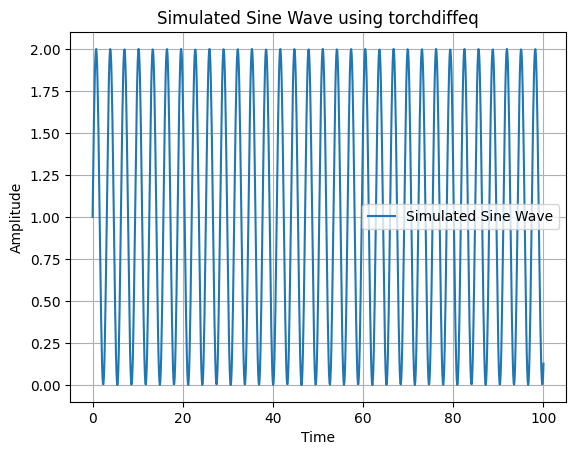

In [5]:
import torch
import torchdiffeq
import matplotlib.pyplot as plt

# Define the parameters for the sine wave ODE
frequency = 2.0  # Frequency of the sine wave
amplitude = 1.0  # Amplitude of the sine wave

# Define the ODE function
def sine_ode(t, y):
    dydt = amplitude * frequency * torch.cos(frequency * t)  # Derivative of the sine wave
    return dydt

# Time points for simulation
t_span = torch.linspace(0, 100, 1000)

# Initial condition (starting value)
initial_condition = torch.tensor([amplitude])

# Solve the ODE using odeint
solution = torchdiffeq.odeint(sine_ode, initial_condition, t_span)

# Extract the simulated values
simulated_values = solution[:, 0]

# Plot the simulated sine wave
plt.plot(t_span, simulated_values, label='Simulated Sine Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Simulated Sine Wave using torchdiffeq')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
solution.shape

torch.Size([1000, 1])

In [23]:
class DWODE(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(DWODE, self).__init__()
        self.lin = nn.Linear(4, 64)
        self.lin2 = nn.Linear(64, 64)
        self.lin3 = nn.Linear(64,4)
        self.elu = nn.ELU()
        

    def forward(self, t,x):
        x = self.elu(self.lin(x))
        x = self.elu(self.lin2(x))
        x = self.lin3(x)
        return x
     

In [24]:
anode = DWODE()
optimizer = torch.optim.Adam(anode.parameters(), lr=1e-3)

In [9]:
def get_batch(true_y, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    #print(indices)
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = t_span[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    return batch_y0,batch_t,batch_y

In [10]:
from torchdiffeq import odeint, odeint_adjoint

In [11]:
solution[0].shape

torch.Size([1])

In [12]:
init = solution[0].reshape(1, -1)

In [13]:
init.shape

torch.Size([1, 1])

In [14]:
aug = torch.zeros(init.shape[0], 1)
            # Shape (batch_size, data_dim + augment_dim)
x_aug = torch.cat([init, aug], 1)

In [15]:
x_aug

tensor([[1., 0.]])

In [16]:
y_pred = odeint_adjoint(anode,x_aug,t_span)
y_pred = y_pred[:,:,:1]

In [17]:
solution.shape

torch.Size([1000, 1])

In [18]:
y_pred.shape

torch.Size([1000, 1, 1])

In [59]:
x_train = solution[:,0]

In [19]:
solution = solution[:600]

Iter 0990 | Total Loss 0.498954


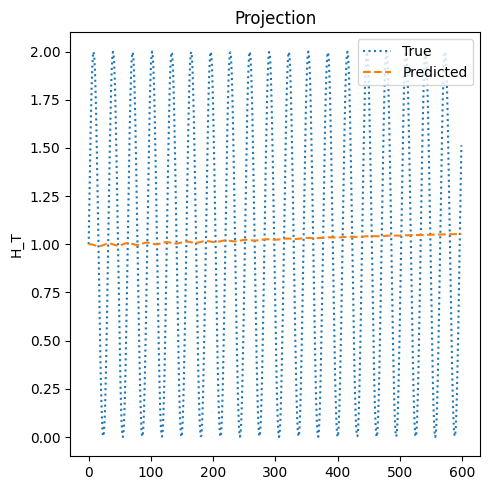

In [25]:
for i in range(1000):          
            optimizer.zero_grad()
            x,t,y = get_batch(solution,30)
            x = x
            y = y
            t = t
            aug = torch.zeros(x.shape[0], 3)
            # Shape (batch_size, data_dim + augment_dim)
            x_aug = torch.cat([x, aug], 1)
            y_pred = odeint_adjoint(anode,x_aug,t)
            y_pred = y_pred[:,:,:1]
            # print('y_pred shape:',y_pred.shape)
            # print(y.shape)
            #print('y_pred',y_pred)
            #print('y',y)
            loss = F.mse_loss(y_pred, y)
            #print('loss:',loss)
            loss.backward()
            optimizer.step()  
            if i % 10 == 0:
                with torch.no_grad():
                    init = solution[0].reshape(1,-1)
                    aug = torch.zeros(init.shape[0], 3)

                    x_aug = torch.cat([init, aug], 1)
                    pred_y = odeint_adjoint(anode,x_aug,t_span[:600])
                    pred_y = pred_y[:,:,:1]
                    #print('pred_y',pred_y.shape)
                    l = solution.reshape(600,1,1)
                    loss = F.mse_loss(pred_y, l)
                    print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
                    x_pred = pred_y[:,:,0]

                    # Extract the x, y, z coordinates from X_train_plt
                    x_train = solution[:,0]

                    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
                    ax.plot(x_train, label='True',linestyle=':')
                    ax.plot(x_pred, label='Predicted', linestyle='--')
                    ax.set_ylabel('H_T')
                    ax.set_title('Projection')
                    ax.legend()

                    plt.tight_layout()
                    plt.show()
                    clear_output(wait=True)